# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [1]:
import os
import sys

import pandas as pd
import tensorflow as tf

# Add the parent directory to the path so that the custom utilities module is found
sys.path.insert(0, "..")

import utilities

g:\Backup\Documents\OpenCampus\Machine Learning With TensorFlow\Project\plain-language-classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model Choice

For the baseline model, I chose a simple bag-of-words model. No pre-trained embeddings are used, with embeddings being trained from scratch instead. The goal is to evaluate how a final model which preserves sequence, possibly with pre-trained embeddings, compares to this baseline model.

## Feature Selection

There are two features in the dataset: The text in form of isolated sequences (sentences) and a binary classifier indicating whether the text is in plain language or not.

## Data Preprocessing

Stop words are removed from the texts. Moreover, data are split into training, validation, and test sets.

In [2]:
has_duplicate_removal = True
has_stop_word_removal = True
validation_size = 0.1
test_size = 0.2

x_training, x_validation, x_test, y_training, y_validation, y_test = (
    utilities.prepare_and_split_data(
        has_duplicate_removal=has_duplicate_removal,
        has_stop_word_removal=has_stop_word_removal,
        validation_size=validation_size,
        test_size=test_size,
    )
)

print(f"Training set size: {len(x_training)}")
print(f"Validation set size: {len(x_validation)}")
print(f"Test set size: {len(x_test)}")

Training set size: 41943
Validation set size: 5992
Test set size: 11984


## Implementation

The baseline model with a single hidden dense layer is implemented and trained.

In [3]:
vocabulary_size = 10_000
maximum_sequence_length = 12
standardization_method = "lower"
dimensions_embedding = 32
units_dense = 8

model = utilities.build_model_baseline(
    x_training=x_training,
    vocabulary_size=vocabulary_size,
    maximum_sequence_length=maximum_sequence_length,
    standardization_method=standardization_method,
    dimensions_embedding=dimensions_embedding,
    units_dense=units_dense,
)

model.summary()

Model: "baseline_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 12)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 12, 32)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_relu (Dense)             │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_sigmoid (Dense)          │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,273 (1.22 MB)

 Trainable params: 320,273 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
is_loading_prepared_model = True

batch_size = 512
patience_early_stopping = 2

if is_loading_prepared_model:
    model.load_weights(filepath=os.path.join("..", "saved_models", "baseline", "baseline.weights.h5"))
    
    data_history = pd.read_csv(os.path.join("..", "saved_models", "baseline", "history_baseline.csv"))
else:
    optimizer = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.BinaryCrossentropy()
    metrics = [tf.keras.metrics.BinaryAccuracy()]
    callback = tf.keras.callbacks.EarlyStopping(
        patience=patience_early_stopping,
        restore_best_weights=True,
        verbose=1,
    )

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    history = model.fit(
        x_training,
        y_training,
        epochs=100,
        batch_size=batch_size,
        validation_data=(x_validation, y_validation),
        callbacks=[callback],
    )
    
    data_history = pd.DataFrame(history.history)
    
    data_history = data_history[data_history.index <= callback.best_epoch]

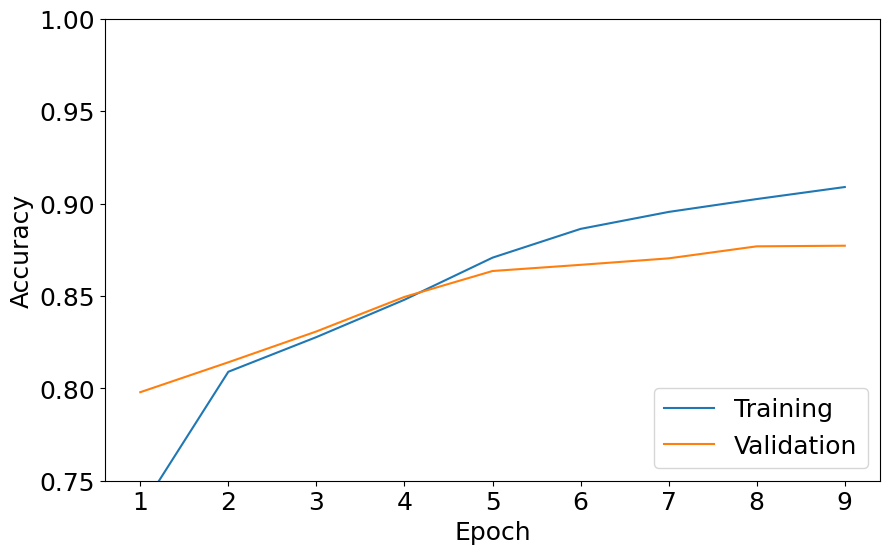

In [5]:
y_limits = (0.75, 1)

_ = utilities.plot_accuracy(data_history=data_history, y_limits=y_limits)

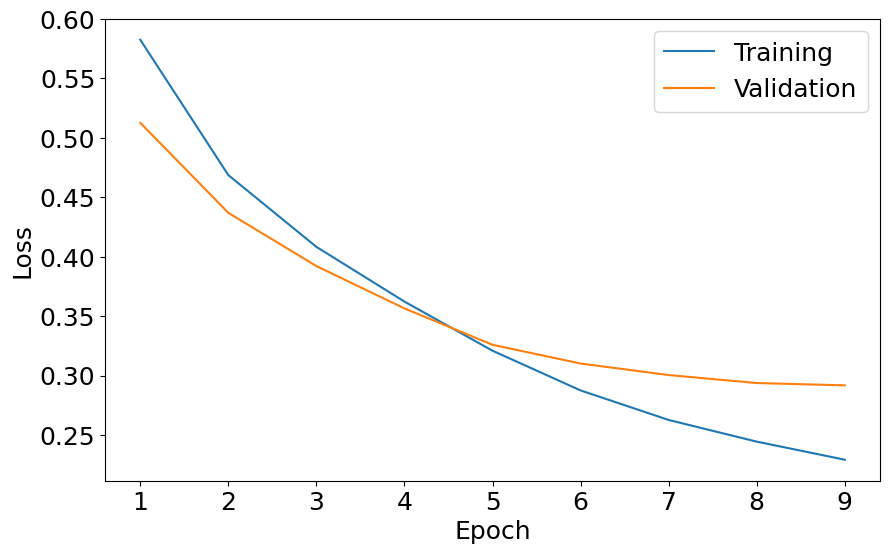

In [6]:
_ = utilities.plot_loss(data_history=data_history)

In [7]:
if not is_loading_prepared_model:
    model.save_weights(filepath=os.path.join("..", "saved_models", "baseline", "baseline.weights.h5"))

    data_history.to_csv(os.path.join("..", "saved_models", "baseline", "history_baseline.csv"), index=False)

## Evaluation

Since there are only two classes, and data are well balanced across the two, accuracy is an adequate measure to evaluate model performance, with little need for more complex measures such as the F1 score. Additionaly, the normalized confusion matrix is plotted to investigate whether there is a general bias towards predicting either plain or regular language.

In [8]:
y_predicted, accuracy = utilities.evaluate_model(model=model, x_test=x_test, y_test=y_test)

print(f"Accuracy: {accuracy * 100:.1f}%")

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 87.4%


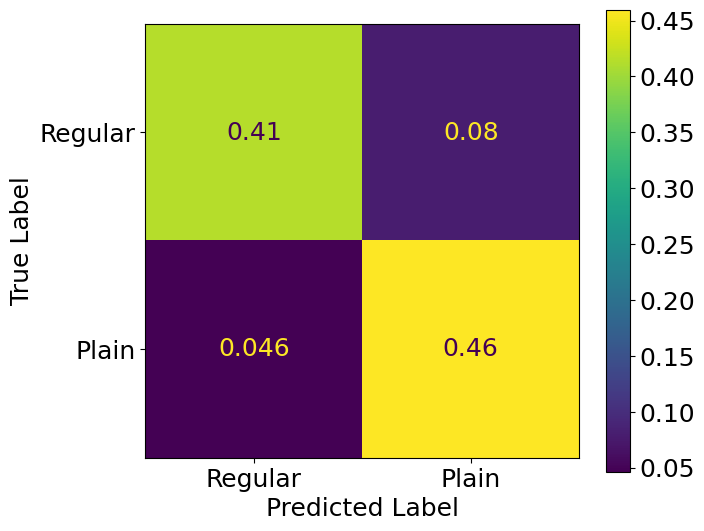

In [9]:
_ = utilities.plot_confusion_matrix(
    y_true=y_test,
    y_predicted=y_predicted,
)